In [2]:
#from dataProcessing import loadData, encodeData, tensorData, removeZeros, zScore
from scipy.stats import zscore
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import json
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

import statsmodels.formula.api as smf
import torch.nn as nn
from torch.nn import (
    Linear,
    ReLU,
    Dropout,
    Sigmoid,
    Softplus,
    LeakyReLU
)
import torch.nn.init as init


import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from torch.distributions import Weibull, Gamma
from statsmodels.genmod import families

import matplotlib.pyplot as plt
import seaborn as sns

import random

In [10]:
def set_seed(seed=42):
    random.seed(seed)                      # Python random
    np.random.seed(seed)                   # NumPy
    torch.manual_seed(seed)                # PyTorch CPU
    torch.cuda.manual_seed(seed)           # PyTorch GPU (para uma GPU)
    torch.cuda.manual_seed_all(seed)       # PyTorch GPU (para várias GPUs)

    # Para garantir determinismo (pode deixar mais lento)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def loadData(
    file_path="https://raw.githubusercontent.com/gabrieldadcarvalho/neural_network/refs/heads/main/projeto/data/insurance.csv",
):
    data = pd.read_csv(file_path)
    data = data.dropna().drop_duplicates()
    return data


def encodeData(data):
    colsObject = [c for c in data.columns if data[c].dtype == "object"]
    data = pd.get_dummies(data, columns=colsObject)
    colsBool = [c for c in data.columns if data[c].dtype == "bool"]
    for c in colsBool:
        data[c] = data[c].astype(int)
    return data


def tensorData(data):
    arr = data.to_numpy()
    return torch.tensor(arr, dtype=torch.float32)


def removeZeros(data):
    data = data[data["charges"] != 0]
    return data

def get_metrics(y_true, y_pred):
    mape = float(np.mean(np.abs((y_true - y_pred) / y_true)) * 100)
    return {
        "MSE": float(mean_squared_error(y_true, y_pred)),
        "RMSE": float(np.sqrt(mean_squared_error(y_true, y_pred))),
        "MAE": float(mean_absolute_error(y_true, y_pred)),
        "MAPE (%)": mape,
        "R²": float(r2_score(y_true, y_pred)),
    }


In [11]:
set_seed(42)

In [12]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

CUDA is not available. Using CPU.


In [13]:
learningRate = 1e-3
n = 1000 #number simulation
d = 0.4 #dropout

# Coleta dos Dados

In [14]:
data = loadData()
print(data.head())

   age     sex     imc  children smoke     region      charges
0   19  female  27.900         0   yes  southwest  16884.92400
1   18    male  33.770         1    no  southeast   1725.55230
2   28    male  33.000         3    no  southeast   4449.46200
3   33    male  22.705         0    no  northwest  21984.47061
4   32    male  28.880         0    no  northwest   3866.85520


# Exploração dos Dados

A análise exploratória foi essencial para entender os padrões de custo de seguro entre diferentes perfis de
indivíduos, antes de ajustar qualquer modelo. Este processo permitiu identificar grupos com custos de
seguro elevados ou baixos, oferecendo insights valiosos sobre os fatores que influenciam essas despesas.
Além disso, a análise ajudou a investigar a correlação entre variáveis, facilitando a aplicação de trans-
formações apropriadas nos dados para melhorar o ajuste do modelo de regressão que será desenvolvido
posteriormente.

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1337 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   object 
 2   imc       1337 non-null   float64
 3   children  1337 non-null   int64  
 4   smoke     1337 non-null   object 
 5   region    1337 non-null   object 
 6   charges   1337 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 83.6+ KB


In [16]:
data[data.duplicated()]

,age,sex,imc,children,smoke,region,charges


In [17]:
data.describe()

,age,imc,children,charges
count,1337.000000,1337.000000,1337.000000,1337.000000
mean,39.222139,30.663452,1.095737,13279.121487
std,14.044333,6.100468,1.205571,12110.359656
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.290000,0.000000,4746.344000
50%,39.000000,30.400000,1.000000,9386.161300
75%,51.000000,34.700000,2.000000,16657.717450
max,64.000000,53.130000,5.000000,63770.428010


In [18]:
data.describe(include='object')

,sex,smoke,region
count,1337,1337,1337
unique,2,2,4
top,male,no,southeast
freq,675,1063,364


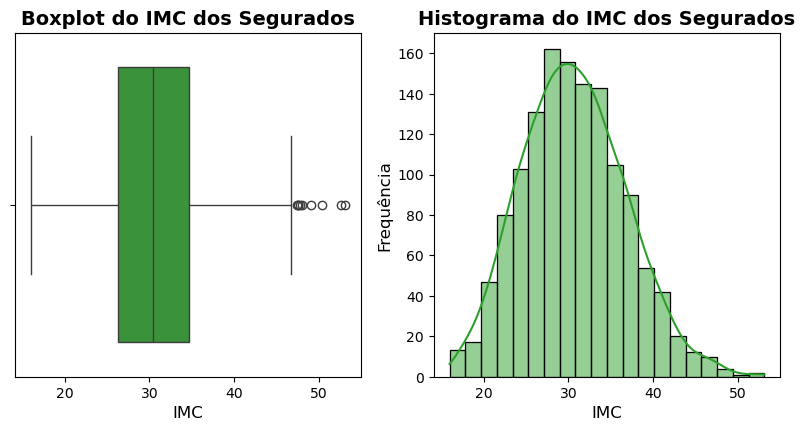

In [19]:
# Tamanho da figura
plt.figure(figsize=(8, 8))

# Cores vibrantes
color_age = "#1f77b4"  # Azul vibrante
color_imc = "#2ca02c"  # Verde vibrante
color_charges = "#d62728"  # Vermelho vibrante
color_children = "#ff7f0e"  # Laranja vibrante

# Boxplot e Histograma para a variável 'imc'
plt.subplot(2, 2, 1)
sns.boxplot(x=data["imc"], color=color_imc)
plt.title("Boxplot do IMC dos Segurados", fontsize=14, fontweight="bold")
plt.xlabel("IMC", fontsize=12)
plt.xticks(fontsize=10)

plt.subplot(2, 2, 2)
sns.histplot(data["imc"], bins=20, kde=True, color=color_imc)
plt.title("Histograma do IMC dos Segurados", fontsize=14, fontweight="bold")
plt.xlabel("IMC", fontsize=12)
plt.ylabel("Frequência", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()

/tmp/ipykernel_108437/4153880725.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


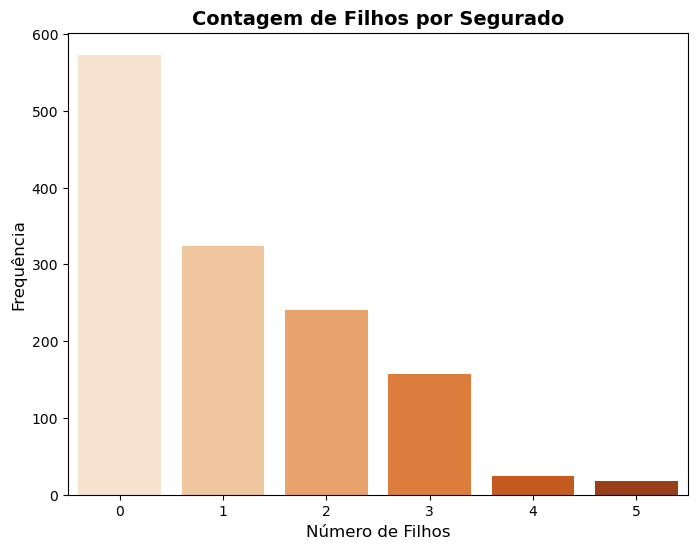

In [20]:
# Tamanho da figura
plt.figure(figsize=(8, 6))
sns.countplot(
    x=data["children"], palette="Oranges"
)  # Gráfico de barras para variável discreta
plt.title("Contagem de Filhos por Segurado", fontsize=14, fontweight="bold")
plt.xlabel("Número de Filhos", fontsize=12)
plt.ylabel("Frequência", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

In [ ]:
# Tamanho da figura
plt.figure(figsize=(10, 10))

sns.boxplot(x=data["charges"], color=color_charges)
plt.title("Boxplot dos Custos de Seguro Saúde", fontsize=14, fontweight="bold")
plt.xlabel("Custo de Seguro Saúde", fontsize=12)
plt.xticks(fontsize=10)
plt.tight_layout()
plt.show()

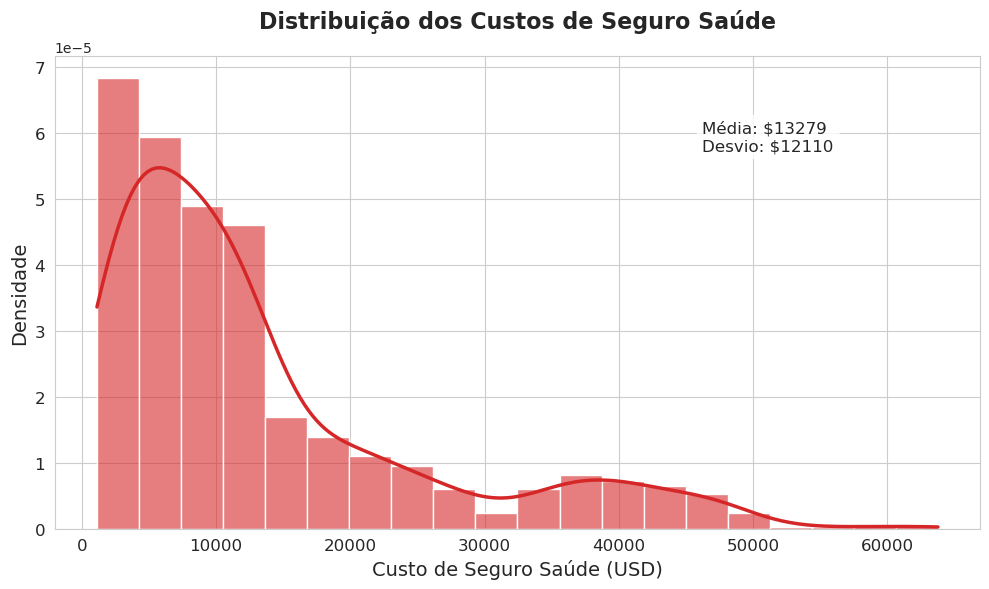

In [28]:
# Usando apenas seaborn para estilo mais acadêmico
plt.figure(figsize=(10, 6))

# Definir estilo
sns.set_style("whitegrid")

# Criar o gráfico combinado
ax = sns.histplot(
    data["charges"],
    bins=20,
    color=color_charges,
    alpha=0.6,
    stat="density",
    kde=True,
    line_kws={"linewidth": 2.5, "color": "#000000"},
)

# Customização para paper acadêmico
ax.set_title(
    "Distribuição dos Custos de Seguro Saúde", fontsize=16, fontweight="bold", pad=20
)
ax.set_xlabel("Custo de Seguro Saúde (USD)", fontsize=14)
ax.set_ylabel("Densidade", fontsize=14)
ax.tick_params(axis="both", which="major", labelsize=12)

# Adicionar estatísticas descritivas como texto
mean_val = data["charges"].mean()
std_val = data["charges"].std()
ax.text(
    0.7,
    0.8,
    f"Média: ${mean_val:.0f}\nDesvio: ${std_val:.0f}",
    transform=ax.transAxes,
    fontsize=12,
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
)

plt.tight_layout()
plt.show()

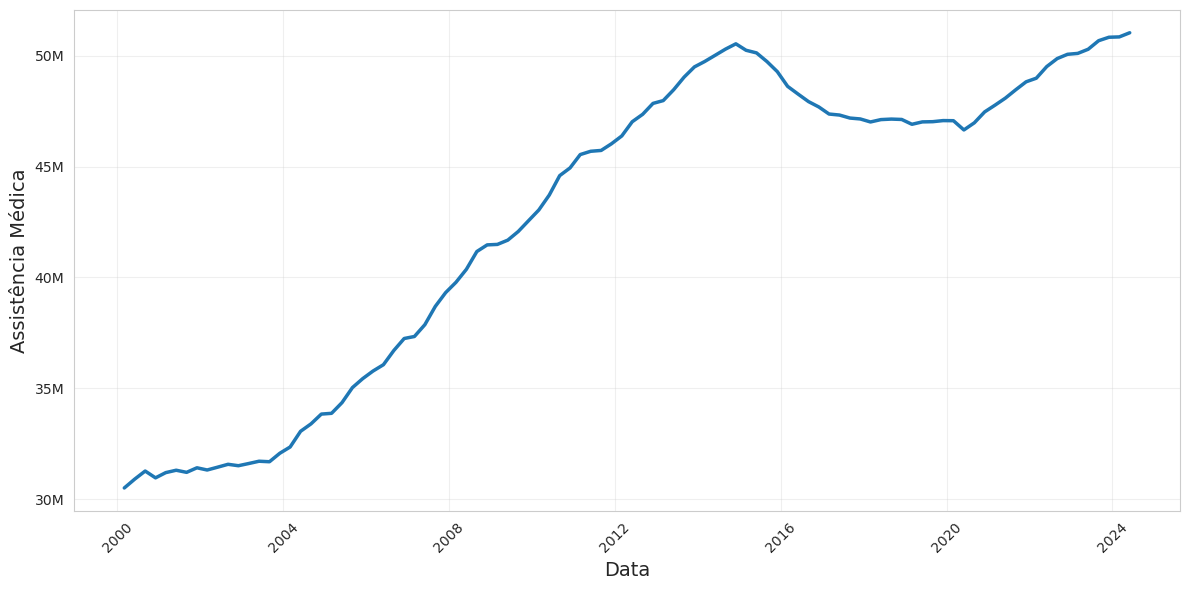

In [33]:
# Carregar dados dos beneficiários
beneficiarios = pd.read_csv(
    "/home/gabrieldadcarvalho/github/neural_network/projeto/data/beneficiarios_ans.csv"
)

# Converter coluna de data para datetime
beneficiarios["data"] = pd.to_datetime(beneficiarios["data"])

# Ordenar por data
beneficiarios = beneficiarios.sort_values("data")

# Criar gráfico linear
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=beneficiarios, x="data", y="Assistência Médica", linewidth=2.5, color="#1f77b4"
)

# Configurações do gráfico
plt.xlabel("Data", fontsize=14)
plt.ylabel("Assistência Médica", fontsize=14)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, alpha=0.3)

# Formatação dos números no eixo Y
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"{x/1e6:.0f}M"))

plt.tight_layout()
plt.show()

<ipython-input-487-b1da2d542f26>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data['sex'], palette='Blues')


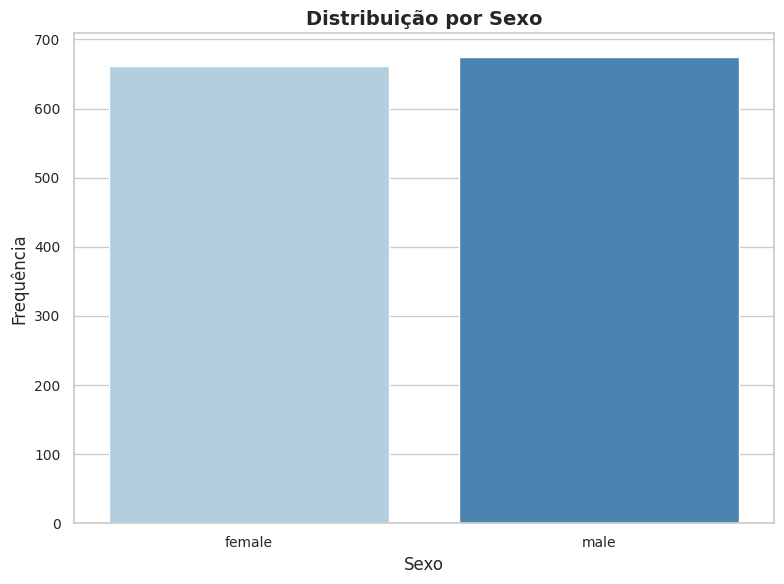

In [487]:
plt.figure(figsize=(8, 6))
sns.countplot(x=data['sex'], palette='Blues')
plt.title('Distribuição por Sexo', fontsize=14, fontweight='bold')
plt.xlabel('Sexo', fontsize=12)
plt.ylabel('Frequência', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

<ipython-input-488-e563ff09b0fa>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data['smoke'], palette='Greens')


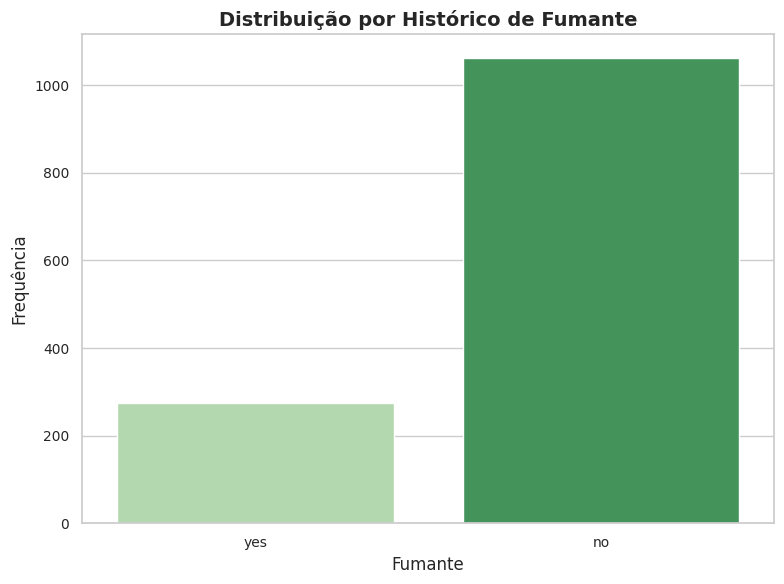

In [488]:
plt.figure(figsize=(8, 6))
sns.countplot(x=data['smoke'], palette='Greens')
plt.title('Distribuição por Histórico de Fumante', fontsize=14, fontweight='bold')
plt.xlabel('Fumante', fontsize=12)
plt.ylabel('Frequência', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


<ipython-input-489-e22ace297539>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data['region'], palette='Oranges')


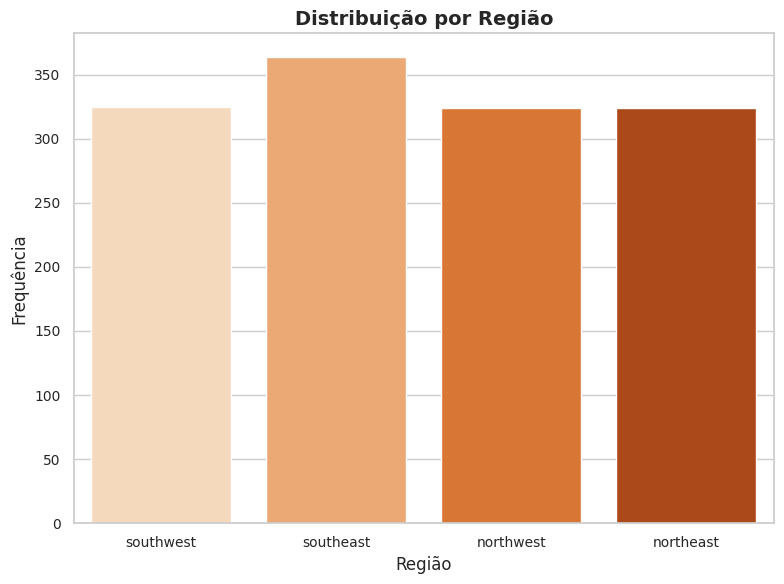

In [489]:
plt.figure(figsize=(8, 6))
sns.countplot(x=data['region'], palette='Oranges')
plt.title('Distribuição por Região', fontsize=14, fontweight='bold')
plt.xlabel('Região', fontsize=12)
plt.ylabel('Frequência', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

<ipython-input-490-73a8ca5452f6>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="region", y="imc", data=data, palette=palette)
<ipython-input-490-73a8ca5452f6>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="region", y="charges", data=data, palette=palette)


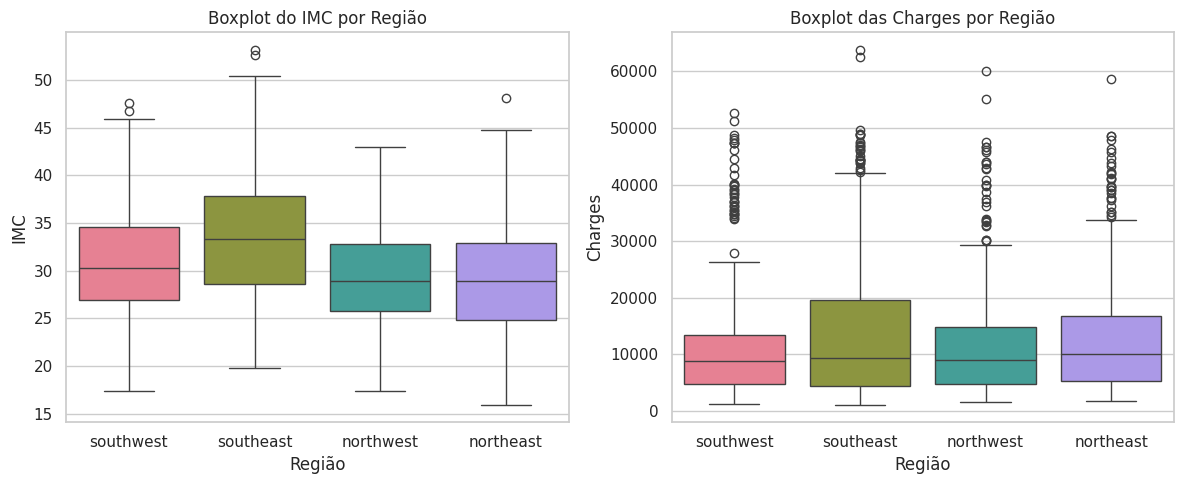

In [490]:
# Configurando o estilo do seaborn
sns.set(style="whitegrid")

# Criando o boxplot do IMC por região
plt.figure(figsize=(12, 5))

# Definindo uma paleta de cores
palette = sns.color_palette("husl", len(data["region"].unique()))

plt.subplot(1, 2, 1)
sns.boxplot(x="region", y="imc", data=data, palette=palette)
plt.title("Boxplot do IMC por Região")
plt.ylabel("IMC")
plt.xlabel("Região")

# Criando o boxplot das Charges por região
plt.subplot(1, 2, 2)
sns.boxplot(x="region", y="charges", data=data, palette=palette)
plt.title("Boxplot das Charges por Região")
plt.ylabel("Charges")
plt.xlabel("Região")

# Ajustar layout
plt.tight_layout()
plt.show()

<ipython-input-491-1f0654a4dbef>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x="age_group", y="charges", palette=colors)
<ipython-input-491-1f0654a4dbef>:11: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.boxplot(data=data, x="age_group", y="charges", palette=colors)


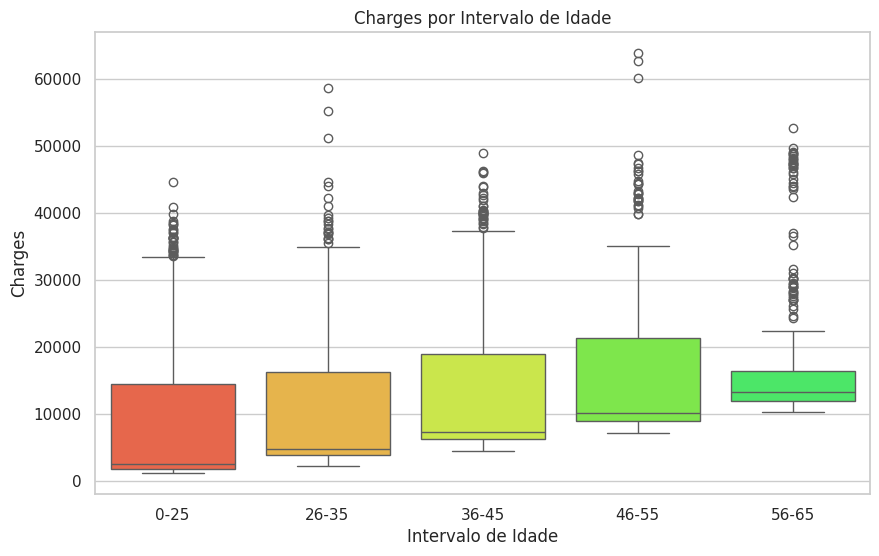

In [491]:
# Dividindo idade em intervalos
bins = [0, 25, 35, 45, 55, 65]
labels = ["0-25", "26-35", "36-45", "46-55", "56-65"]
data["age_group"] = pd.cut(data["age"], bins=bins, labels=labels, right=False)

# Definindo cores mais fortes para cada grupo etário
colors = ["#FF5733", "#FFBD33", "#DBFF33", "#75FF33", "#33FF57", "#3357FF"]

# Criando o boxplot com cores mais fortes
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x="age_group", y="charges", palette=colors)
plt.title("Charges por Intervalo de Idade")
plt.xlabel("Intervalo de Idade")
plt.ylabel("Charges")
plt.show()

In [492]:
data = data.drop(columns=["age_group"])

# Data Transformation

In [493]:
dataT = encodeData(data.copy())
dataT.head()

,age,imc,children,charges,sex_female,sex_male,smoke_no,smoke_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,1,0,0,1,0,0,0,1
1,18,33.770,1,1725.55230,0,1,1,0,0,0,1,0
2,28,33.000,3,4449.46200,0,1,1,0,0,0,1,0
3,33,22.705,0,21984.47061,0,1,1,0,0,1,0,0
4,32,28.880,0,3866.85520,0,1,1,0,0,1,0,0


In [494]:
X_train, X_test, y_train, y_test = train_test_split(
    dataT.drop(columns=["charges"]), dataT["charges"], test_size=0.2, random_state=42
)

MeanX = [X_train["age"].mean(), X_train["imc"].mean()]
StdX = [X_train["age"].std(), X_train["imc"].std()]

X_train["age"] = (X_train["age"] - X_train["age"].mean()) / X_train["age"].std()
X_train["imc"] = (X_train["imc"] - X_train["imc"].mean()) / X_train["imc"].std()

X_test['age'] = (X_test["age"] - MeanX[0]) / StdX[0]
X_test['imc'] = (X_test["imc"] - MeanX[1]) / StdX[1]


if isinstance(X_train, pd.DataFrame):
    X_train_np = X_train.values
else:
    X_train_np = X_train

if isinstance(y_train, pd.Series):
    y_train_np = y_train.values
else:
    y_train_np = y_train


In [495]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

In [496]:
if isinstance(X_train, pd.DataFrame):
    X_train_np = X_train.values
else:
    X_train_np = X_train

if isinstance(y_train, pd.Series):
    y_train_np = y_train.values
else:
    y_train_np = y_train

# Máscara para valores altos
mask_high = y_train_np >= 30000
mask_low = ~mask_high

# Separar os conjuntos
X_high = X_train_np[mask_high]
y_high = y_train_np[mask_high]

X_low = X_train_np[mask_low]
y_low = y_train_np[mask_low]

X_high_upsampled, y_high_upsampled = resample(
    X_high, y_high,
    replace=True,
    n_samples=len(y_test), # amostragem com reposição
    random_state=42
)

X_train_balanced = np.concatenate([X_low, X_high_upsampled])
y_train_balanced = np.concatenate([y_low, y_high_upsampled])

X_train_balanced = pd.DataFrame(X_train_balanced, columns=X_train.columns)
y_train_balanced = pd.Series(y_train_balanced)

In [497]:
dataTrainGml= X_train_balanced.copy()
dataTrainGml["charges"] = y_train_balanced

X_train_tensor = torch.tensor(X_train_balanced.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_balanced.values, dtype=torch.float32).squeeze()

X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).squeeze()

X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).squeeze().to(device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [498]:
actuals_test = y_test_tensor.cpu().numpy().flatten()
actuals_train = y_train_tensor.cpu().numpy().flatten()
actuals_val = y_val_tensor.cpu().numpy().flatten()

# GML

In [499]:
formula = (
    "charges ~ age + imc + children + "
    "sex_female + sex_male + smoke_no + smoke_yes + "
    "region_northeast + region_northwest + region_southeast + region_southwest"
)
fam = families.Gamma(link=families.links.log())

/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


In [500]:
glmG = smf.glm(data=dataTrainGml, formula=formula, family=fam)

In [501]:
glmGamma = glmG.fit(maxiter=n)

In [502]:
glmGamma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                charges   No. Observations:                 1027
Model:                            GLM   Df Residuals:                     1018
Model Family:                   Gamma   Df Model:                            8
Link Function:                    log   Scale:                         0.40031
Method:                          IRLS   Log-Likelihood:                -10437.
Date:                Fri, 23 May 2025   Deviance:                       261.43
Time:                        12:30:42   Pearson chi2:                     416.
No. Iterations:                  1000   Pseudo R-squ. (CS):             0.7867
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            4.2873      0.013    331.833      0.000       4.262       4.313
age                  0.3287      0.020     16.713      0.000       0.290       0.367
imc                  0.1026      0.021      4.916      0.000       0.062       0.144
children             0.0700      0.017      4.139      0.000       0.037       0.103
sex_female           2.1610      0.022     98.685      0.000       2.118       2.204
sex_male             2.1263      0.020    104.659      0.000       2.087       2.166
smoke_no             1.3705      0.021     66.339      0.000       1.330       1.411
smoke_yes            2.9169      0.025    118.618      0.000       2.869       2.965
region_northeast     1.1144      0.036     30.929      0.000       1.044       1.185
region_northwest     1.0929      0.037     29.794      0.000       1.021       1.165
region_southeast     1.0088      0.034     29.766      0.000       0.942       1.075
region_southwest     1.0713      0.034     31.133      0.000       1.004       1.139
====================================================================================
"""

In [503]:
# 1) Extrai coeficientes e escala
params = glmGamma.params.to_dict()      # dicionário de coeficientes, inclusive intercept
scale  = float(glmGamma.scale)          # dispersão
link   = glmGamma.family.link.__class__.__name__  # nome do link

# 2) Empacota num dicionário
model_info = {
    "params": params,
    "scale": scale,
    "link": link,
}

# 3) Salva como JSON
with open("gml_params.json", "w") as f:
    json.dump(model_info, f, indent=2)

In [504]:
glmGbeta_np = glmGamma.params.values
glmGbeta = torch.tensor(glmGbeta_np, dtype=torch.float32).to(device)
input_dim = len(glmGbeta_np) - 1

# CANN

In [505]:
class CANN(nn.Module):
    def __init__(self, input_dim, beta, dropout=0.2):
        super().__init__()
        self.net1= nn.Linear(input_dim, 128)
        self.net2 = nn.Linear(128, 256)
        self.net3 = nn.Linear(256, 128)
        self.net4= nn.Linear(128, 64)
        self.outConc = nn.Linear(64, 1)

        # Parâmetros escalar w e b
        self.w = nn.Parameter(torch.tensor(1.0))
        self.wg = nn.Parameter(torch.tensor(1.0))
        self.b = nn.Parameter(torch.tensor(0.0))

        self.relu = nn.ReLU()
        self.softplus = nn.Softplus()
        self.dropout = nn.Dropout(dropout)

        # Beta do modelo GML (coeficientes), não treinável
        if not isinstance(beta, torch.Tensor):
            beta = torch.tensor(beta, dtype=torch.float32)
        self.register_buffer("beta", beta)

    def forward(self, x):
        # 1) GML log-linear
        intercept = torch.ones(x.size(0), 1, device=x.device)
        XWithIntercept = torch.cat([intercept, x], dim=1)
        logGml = XWithIntercept @ self.beta.to(x.device)

        # 2) Parte MLP
        h = self.relu(self.net1(x))
        h = self.dropout(h)
        h = self.relu(self.net2(h))
        h = self.dropout(h)
        h = self.relu(self.net3(h))
        h = self.dropout(h)
        h = self.relu(self.net4(h))
        h = self.dropout(h)
        net = self.softplus(self.outConc(h)).squeeze(-1) + 1e-6

        out = torch.exp(self.w * net + self.wg * logGml + self.b)

        return out

In [506]:
# Modelo já criado (lembre de passar beta)
modelCANN = CANN(input_dim=X_train_tensor.shape[1], beta=glmGbeta_np).to(device)
modelCANN.train()


criterion = (
    torch.nn.MSELoss()
)

optimizer = torch.optim.Adam(modelCANN.parameters(), lr=learningRate)

# 4. Listas para histórico
recodLossCann = {
    'train_loss': [],
    'val_loss': []
}


In [507]:
# 5. Loop de treinamento com validação
num_epochs = n
for epoch in range(1, num_epochs + 1):
    # --- Treino ---
    modelCANN.train()
    running_train = 0.0
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        optimizer.zero_grad()
        preds = modelCANN(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        running_train += loss.item() * xb.size(0)
    epoch_train_loss = running_train / len(train_loader.dataset)

    # --- Validação ---
    modelCANN.eval()
    running_val = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            preds = modelCANN(xb)
            loss = criterion(preds, yb)
            running_val += loss.item() * xb.size(0)
    epoch_val_loss = running_val / len(val_loader.dataset)

    # Guarda os valores num dicionário
    recodLossCann['train_loss'].append(epoch_train_loss)
    recodLossCann["val_loss"].append(epoch_val_loss)

    print(
    f"Epoch {epoch:3d}/{num_epochs}  "
    f"Train Loss: {epoch_train_loss:.4f}  "
    f"Val   Loss: {epoch_val_loss:.4f}"
)

# Depois do loop, salva tudo num JSON:
with open("lossesCann.json", "w") as f:
    json.dump(recodLossCann, f, indent=4)

Epoch   1/1000  Train Loss: 328919183.6105  Val   Loss: 43619218.1682
Epoch   2/1000  Train Loss: 67389981.1538  Val   Loss: 43643766.9626
Epoch   3/1000  Train Loss: 68583956.0974  Val   Loss: 43677166.4393
Epoch   4/1000  Train Loss: 68407156.1675  Val   Loss: 43616434.1589
Epoch   5/1000  Train Loss: 68052010.2882  Val   Loss: 43592039.2523
Epoch   6/1000  Train Loss: 67672846.3408  Val   Loss: 43561820.5607
Epoch   7/1000  Train Loss: 67282684.6760  Val   Loss: 43391255.0841
Epoch   8/1000  Train Loss: 64022827.4352  Val   Loss: 40746781.7850
Epoch   9/1000  Train Loss: 51953246.6835  Val   Loss: 36115943.3458
Epoch  10/1000  Train Loss: 44604047.8286  Val   Loss: 34322023.6355
Epoch  11/1000  Train Loss: 41423001.0204  Val   Loss: 33799776.4112
Epoch  12/1000  Train Loss: 38405397.1943  Val   Loss: 33147095.2523
Epoch  13/1000  Train Loss: 37167482.2478  Val   Loss: 33099803.2710
Epoch  14/1000  Train Loss: 36772122.6875  Val   Loss: 32640209.1215
Epoch  15/1000  Train Loss: 36480

In [508]:
model_path = "cann.pth"

# Salvar o estado do modelo
torch.save(modelCANN.state_dict(), model_path)

print(f"Modelo salvo em {model_path}")

Modelo salvo em cann.pth


# PANN

In [509]:
class PANN(nn.Module):
    def __init__(self, input_dim, shape=0.3, dropout=0.2):
        super().__init__()
        self.net1= nn.Linear(input_dim, 128)
        self.net2 = nn.Linear(128, 256)
        self.net3 = nn.Linear(256, 128)
        self.net4= nn.Linear(128, 64)
        self.outScale = nn.Linear(64, 1)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.shape = shape

    def forward(self, x):
        h = self.relu(self.net1(x))
        h = self.dropout(h)
        h = self.relu(self.net2(h))
        h = self.dropout(h)
        h = self.relu(self.net3(h))
        h = self.dropout(h)
        h = self.relu(self.net4(h))
        h = self.dropout(h)
        scale = self.relu(self.outScale(h)).squeeze(-1) + 1e-6

        dist = Weibull(scale=scale, concentration=self.shape)

        out = dist.mean

        return out

In [510]:
# Modelo já criado (lembre de passar beta)
modelPANN = PANN(input_dim=X_train_tensor.shape[1],shape=0.3, dropout=d).to(device)
modelPANN.train()

optimizer = torch.optim.Adam(modelPANN.parameters(), lr=learningRate)

# 4. Listas para histórico
recodLossPann = {
    'train_loss': [],
    'val_loss': []
}

criterion = (
    torch.nn.MSELoss()
)

In [511]:
# 5. Loop de treinamento com validação
num_epochs = n
for epoch in range(1, num_epochs + 1):
    # --- Treino ---
    modelPANN.train()
    running_train = 0.0
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        optimizer.zero_grad()
        preds = modelPANN(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        running_train += loss.item() * xb.size(0)
    epoch_train_loss = running_train / len(train_loader.dataset)

    # --- Validação ---
    modelPANN.eval()
    running_val = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            preds = modelPANN(xb)
            loss = criterion(preds, yb)
            running_val += loss.item() * xb.size(0)
    epoch_val_loss = running_val / len(val_loader.dataset)

    # Guarda os valores num dicionário
    recodLossPann['train_loss'].append(epoch_train_loss)
    recodLossPann["val_loss"].append(epoch_val_loss)

    print(
    f"Epoch {epoch:3d}/{num_epochs}  "
    f"Train Loss: {epoch_train_loss:.4f}  "
    f"Val   Loss: {epoch_val_loss:.4f}"
)

# Depois do loop, salva tudo num JSON:
with open("lossesPann.json", "w") as f:
    json.dump(recodLossPann, f, indent=4)

Epoch   1/1000  Train Loss: 546485333.5696  Val   Loss: 284844235.6636
Epoch   2/1000  Train Loss: 539988335.5482  Val   Loss: 268407705.1963
Epoch   3/1000  Train Loss: 470844812.7692  Val   Loss: 166006233.2336
Epoch   4/1000  Train Loss: 273028657.6047  Val   Loss: 182623613.0093
Epoch   5/1000  Train Loss: 202171685.9202  Val   Loss: 105926024.3738
Epoch   6/1000  Train Loss: 178058582.1577  Val   Loss: 100324985.5701
Epoch   7/1000  Train Loss: 146491189.1100  Val   Loss: 88141325.3084
Epoch   8/1000  Train Loss: 116404312.8179  Val   Loss: 73112357.9813
Epoch   9/1000  Train Loss: 102034300.1207  Val   Loss: 57442108.7103
Epoch  10/1000  Train Loss: 77539493.2970  Val   Loss: 45566487.6262
Epoch  11/1000  Train Loss: 73331192.7790  Val   Loss: 39347565.8692
Epoch  12/1000  Train Loss: 69015279.0312  Val   Loss: 36013954.8411
Epoch  13/1000  Train Loss: 60356279.8189  Val   Loss: 33010178.4579
Epoch  14/1000  Train Loss: 59204926.1772  Val   Loss: 32210291.1963
Epoch  15/1000  Tra

In [512]:
model_path = "pann.pth"

# Salvar o estado do modelo
torch.save(modelPANN.state_dict(), model_path)

print(f"Modelo salvo em {model_path}")

Modelo salvo em pann.pth


# MLP

In [513]:
class MLP(nn.Module):
    def __init__(self, input_dim, dropout=0.2):
        super().__init__()
        self.net1= nn.Linear(input_dim, 128)
        self.net2 = nn.Linear(128, 256)
        self.net3 = nn.Linear(256, 128)
        self.net4= nn.Linear(128, 64)
        self.output_layer = nn.Linear(64, 1)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        h = self.relu(self.net1(x))
        h = self.dropout(h)
        h = self.relu(self.net2(h))
        h = self.dropout(h)
        h = self.relu(self.net3(h))
        h = self.dropout(h)
        h = self.relu(self.net4(h))
        h = self.dropout(h)

        out = self.output_layer(h).squeeze(-1)
        return out

In [514]:
# Modelo já criado (lembre de passar beta)
modelMLP = MLP(input_dim=X_train_tensor.shape[1], dropout=d).to(device)
modelMLP.train()

optimizer = torch.optim.Adam(modelMLP.parameters(), lr=learningRate)

# 4. Listas para histórico
recodLossMLP = {
    'train_loss': [],
    'val_loss': []
}

criterion = (
    torch.nn.MSELoss()
)


In [515]:
num_epochs = n
for epoch in range(1, num_epochs + 1):
    # --- Treino ---
    modelMLP.train()
    running_train = 0.0
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        optimizer.zero_grad()
        preds = modelMLP(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        running_train += loss.item() * xb.size(0)
    epoch_train_loss = running_train / len(train_loader.dataset)

    # --- Validação ---
    modelMLP.eval()
    running_val = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            preds = modelMLP(xb)
            loss = criterion(preds, yb)
            running_val += loss.item() * xb.size(0)
    epoch_val_loss = running_val / len(val_loader.dataset)


    recodLossMLP["train_loss"].append(epoch_train_loss)
    recodLossMLP["val_loss"].append(epoch_val_loss)

    print(
        f"Epoch {epoch:3d}/{num_epochs}  "
        f"Train Loss: {epoch_train_loss:.4f}  "
        f"Val   Loss: {epoch_val_loss:.4f}"
    )


with open("lossesMLP.json", "w") as f:
    json.dump(recodLossMLP, f, indent=4)

Epoch   1/1000  Train Loss: 546651989.4372  Val   Loss: 285473950.5047
Epoch   2/1000  Train Loss: 545944979.3807  Val   Loss: 283799585.3458
Epoch   3/1000  Train Loss: 538673634.2123  Val   Loss: 270121627.8879
Epoch   4/1000  Train Loss: 493497270.9640  Val   Loss: 207223241.3458
Epoch   5/1000  Train Loss: 351559517.9124  Val   Loss: 113564428.2991
Epoch   6/1000  Train Loss: 219748659.7858  Val   Loss: 134283149.2336
Epoch   7/1000  Train Loss: 183710311.9455  Val   Loss: 104038644.4860
Epoch   8/1000  Train Loss: 167234325.7429  Val   Loss: 92629148.8598
Epoch   9/1000  Train Loss: 150942815.9688  Val   Loss: 88596986.0935
Epoch  10/1000  Train Loss: 129259055.5482  Val   Loss: 82254125.0467
Epoch  11/1000  Train Loss: 117418806.9017  Val   Loss: 65215908.0374
Epoch  12/1000  Train Loss: 102203131.5833  Val   Loss: 59532777.1589
Epoch  13/1000  Train Loss: 88305845.0477  Val   Loss: 51831868.1121
Epoch  14/1000  Train Loss: 78615881.2853  Val   Loss: 45909224.5047
Epoch  15/1000 

In [516]:
model_path = "mlp.pth"

torch.save(modelMLP.state_dict(), model_path)

print(f"Modelo salvo em {model_path}")

Modelo salvo em mlp.pth


In [517]:
modelCANN.eval()
modelPANN.eval()
modelMLP.eval()


X_test_with_intercept = np.hstack([np.ones((X_test.shape[0], 1)), X_test])
X_val_with_intercept = np.hstack([np.ones((X_val.shape[0], 1)), X_val])
X_train_with_intercept = np.hstack([np.ones((X_train_balanced.shape[0], 1)), X_train_balanced])

with torch.no_grad():
    preds_test_cann = modelCANN(X_test_tensor.to(device))
    preds_val_cann = modelCANN(X_val_tensor.to(device))
    preds_train_cann = modelCANN(X_train_tensor.to(device))

    preds_test_pann = modelPANN(X_test_tensor.to(device))
    preds_val_pann = modelPANN(X_val_tensor.to(device))
    preds_train_pann = modelPANN(X_train_tensor.to(device))

    preds_test_mlp = modelMLP(X_test_tensor.to(device))
    preds_val_mlp = modelMLP(X_val_tensor.to(device))
    preds_train_mlp = modelMLP(X_train_tensor.to(device))


preds_train_glm = np.exp(X_train_with_intercept @ glmGbeta_np)
preds_val_glm = np.exp(X_val_with_intercept @ glmGbeta_np)
preds_test_glm = np.exp(X_test_with_intercept @ glmGbeta_np)

preds_test_cann = preds_test_cann.cpu().numpy().flatten()
preds_val_cann = preds_val_cann.cpu().numpy().flatten()
preds_train_cann = preds_train_cann.cpu().numpy().flatten()

preds_test_pann = preds_test_pann.cpu().numpy().flatten()
preds_val_pann = preds_val_pann.cpu().numpy().flatten()
preds_train_pann = preds_train_pann.cpu().numpy().flatten()

preds_test_mlp = preds_test_mlp.cpu().numpy().flatten()
preds_val_mlp = preds_val_mlp.cpu().numpy().flatten()
preds_train_mlp = preds_train_mlp.cpu().numpy().flatten()


residuals_test_glm = actuals_test - preds_test_glm
residuals_val_glm = actuals_val - preds_val_glm
residuals_train_glm = actuals_train - preds_train_glm

residuals_test_pann = actuals_test - preds_test_pann
residuals_val_pann = actuals_val - preds_val_pann
residuals_train_pann = actuals_train - preds_train_pann

residuals_test_mlp = actuals_test - preds_test_mlp
residuals_val_mlp = actuals_val - preds_val_mlp
residuals_train_mlp = actuals_train - preds_train_mlp

residuals_test_cann = actuals_test - preds_test_cann
residuals_val_cann = actuals_val - preds_val_cann
residuals_train_cann = actuals_train - preds_train_cann


wast = {
    "glm": {
        "train": residuals_train_glm.tolist(),
        "validation": residuals_val_glm.tolist(),
        "test": residuals_test_glm.tolist(),
    },
    "cann": {
        "train": residuals_train_cann.tolist(),
        "validation": residuals_val_cann.tolist(),
        "test": residuals_test_cann.tolist(),
    },
    "pann": {
        "train": residuals_train_pann.tolist(),
        "validation": residuals_val_pann.tolist(),
        "test": residuals_test_pann.tolist(),
    },
    "mlp": {
        "train": residuals_train_mlp.tolist(),
        "validation": residuals_val_mlp.tolist(),
        "test": residuals_test_mlp.tolist(),
    },
}

with open("wast.json", "w") as f:
    json.dump(wast, f, indent=4)

# SALVAR RESULTADOS DO TESTE
metrics = {
    "glm": {
        "train": get_metrics(actuals_train, preds_train_glm),
        "validation": get_metrics(actuals_val, preds_val_glm),
        "test": get_metrics(actuals_test, preds_test_glm),
    },
    "cann": {
        "train": get_metrics(actuals_train, preds_train_cann),
        "validation": get_metrics(actuals_val, preds_val_cann),
        "test": get_metrics(actuals_test, preds_test_cann),
    },
    "pann": {
        "train": get_metrics(actuals_train, preds_train_pann),
        "validation": get_metrics(actuals_val, preds_val_pann),
        "test": get_metrics(actuals_test, preds_test_pann),
    },
    "mlp": {
        "train": get_metrics(actuals_train, preds_train_mlp),
        "validation": get_metrics(actuals_val, preds_val_mlp),
        "test": get_metrics(actuals_test, preds_test_mlp),
    },
}

with open("metrics.json", "w") as f:
    json.dump(metrics, f, indent=4)

In [518]:
# Flatten the nested dictionary into a list of rows
rows = []
for model_name, dataset_dict in metrics.items():
    for dataset_name, metric_dict in dataset_dict.items():
        row = {
            "Modelo": model_name.upper(),
            "Conjunto": dataset_name.capitalize()
        }
        row.update(metric_dict)
        rows.append(row)

# Criar DataFrame
metrics_df = pd.DataFrame(rows)

# Organizar colunas
metrics_df = metrics_df[["Modelo", "Conjunto", "MSE", "RMSE", "MAE", "MAPE (%)", "R²"]]

# Exibir tabela
print(metrics_df.to_string(index=False))

# Salvar como CSV (opcional)
metrics_df.to_csv("metrics_table.csv", index=False)

Modelo   Conjunto          MSE        RMSE         MAE  MAPE (%)       R²
   GLM      Train 8.046565e+07 8970.264642 5782.177655 42.883631 0.650455
   GLM Validation 5.275945e+07 7263.569952 4271.884809 42.645585 0.581842
   GLM       Test 4.214580e+07 6491.979520 3946.140754 44.036211 0.770643
  CANN      Train 2.725592e+06 1650.936704  907.632935 11.396254 0.988160
  CANN Validation 2.944149e+07 5426.001290 2755.444580 25.545179 0.766654
  CANN       Test 3.168113e+07 5628.599115 2886.780273 33.812698 0.827591
  PANN      Train 1.606543e+07 4008.170281 2113.084717 21.235401 0.930211
  PANN Validation 2.455008e+07 4954.804133 2582.165771 28.735188 0.805422
  PANN       Test 2.126252e+07 4611.129580 2444.342773 28.454748 0.884289
   MLP      Train 1.773793e+07 4211.642435 2403.021484 26.071384 0.922946
   MLP Validation 2.391966e+07 4890.773354 2866.687988 34.908054 0.810419
   MLP       Test 1.969101e+07 4437.455577 2564.801514 32.963341 0.892842


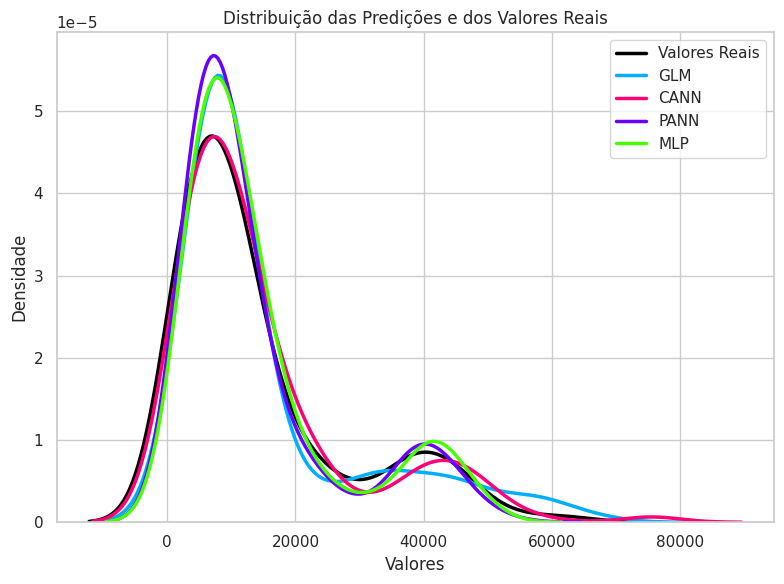

In [519]:
plt.figure(figsize=(8, 6))

sns.kdeplot(actuals_test, color='#000000', linewidth=2.5, label='Valores Reais')
sns.kdeplot(preds_test_glm, color='#00aeff', linewidth=2.5, label='GLM')
sns.kdeplot(preds_test_cann, color='#ff0077', linewidth=2.5, label='CANN')
sns.kdeplot(preds_test_pann, color='#6a00ff', linewidth=2.5, label='PANN')  # Tom mais forte que #FB9A99
sns.kdeplot(preds_test_mlp, color='#48ff00', linewidth=2.5, label='MLP')

plt.xlabel("Valores")
plt.ylabel("Densidade")
plt.title("Distribuição das Predições e dos Valores Reais")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

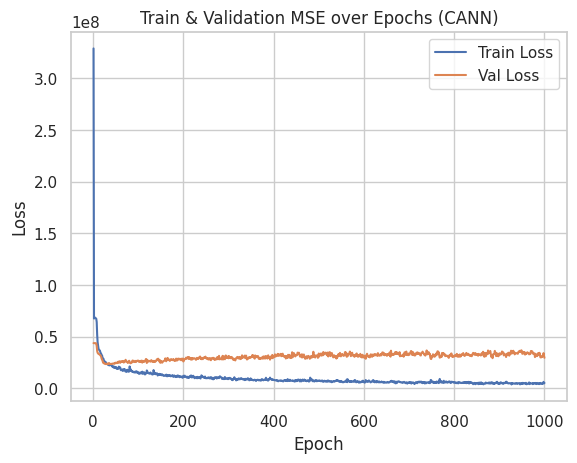

In [520]:
plt.figure()
plt.plot(range(1, num_epochs + 1), recodLossCann['train_loss'], label="Train Loss")
plt.plot(range(1, num_epochs + 1), recodLossCann['val_loss'], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train & Validation MSE over Epochs (CANN)")
plt.legend()
plt.show()

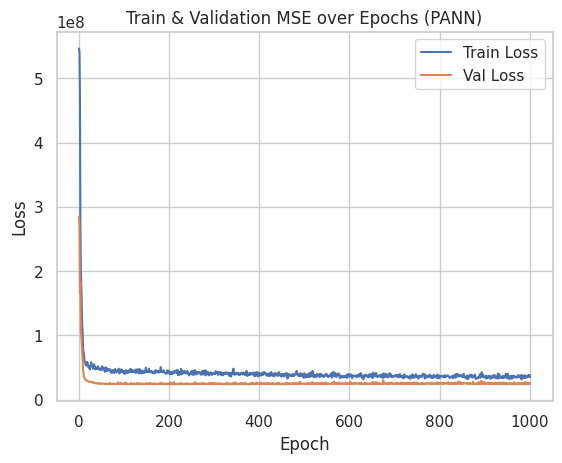

In [521]:
plt.figure()
plt.plot(range(1, num_epochs + 1), recodLossPann['train_loss'], label="Train Loss")
plt.plot(range(1, num_epochs + 1), recodLossPann['val_loss'], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train & Validation MSE over Epochs (PANN)")
plt.legend()
plt.show()

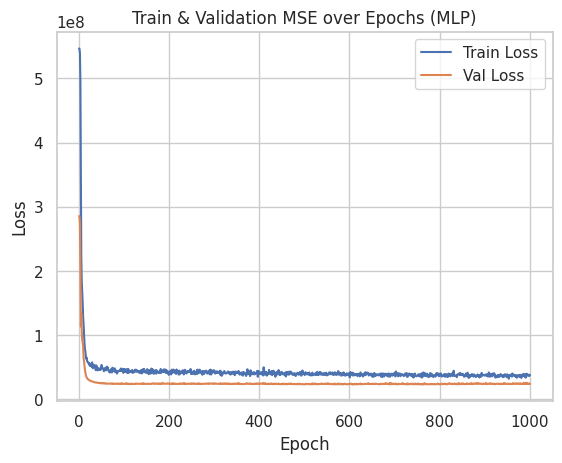

In [522]:
plt.figure()
plt.plot(range(1, num_epochs + 1), recodLossMLP['train_loss'], label="Train Loss")
plt.plot(range(1, num_epochs + 1), recodLossMLP['val_loss'], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train & Validation MSE over Epochs (MLP)")
plt.legend()
plt.show()

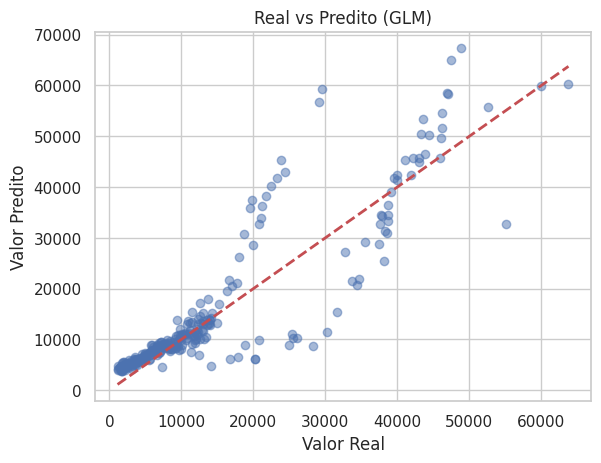

In [523]:
plt.scatter(actuals_test, preds_test_glm, alpha=0.5)
plt.xlabel("Valor Real")
plt.ylabel("Valor Predito")
plt.title("Real vs Predito (GLM)")
plt.plot([actuals_test.min(), actuals_test.max()], [actuals_test.min(), actuals_test.max()], 'r--', linewidth=2)
plt.show()

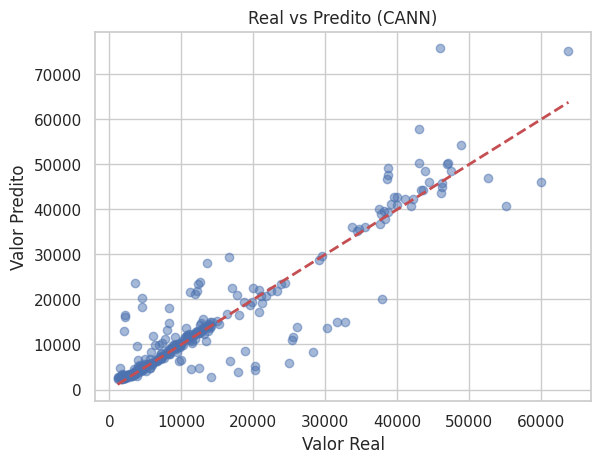

In [524]:
plt.scatter(actuals_test, preds_test_cann, alpha=0.5)
plt.xlabel("Valor Real")
plt.ylabel("Valor Predito")
plt.title("Real vs Predito (CANN)")
plt.plot([actuals_test.min(), actuals_test.max()], [actuals_test.min(), actuals_test.max()], 'r--', linewidth=2)
plt.show()

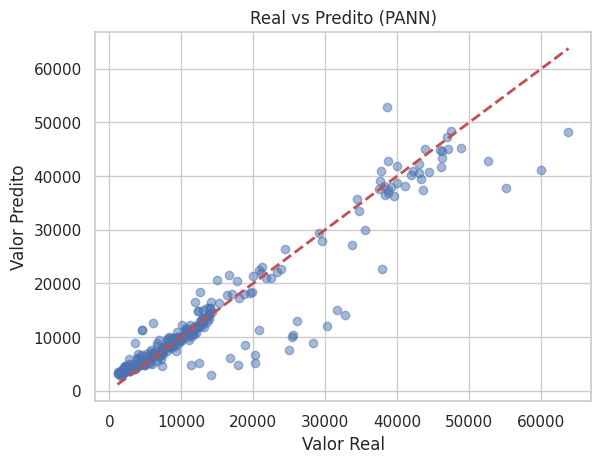

In [525]:
plt.scatter(actuals_test, preds_test_pann, alpha=0.5)
plt.xlabel("Valor Real")
plt.ylabel("Valor Predito")
plt.title("Real vs Predito (PANN)")
plt.plot([actuals_test.min(), actuals_test.max()], [actuals_test.min(), actuals_test.max()], 'r--', linewidth=2)
plt.show()

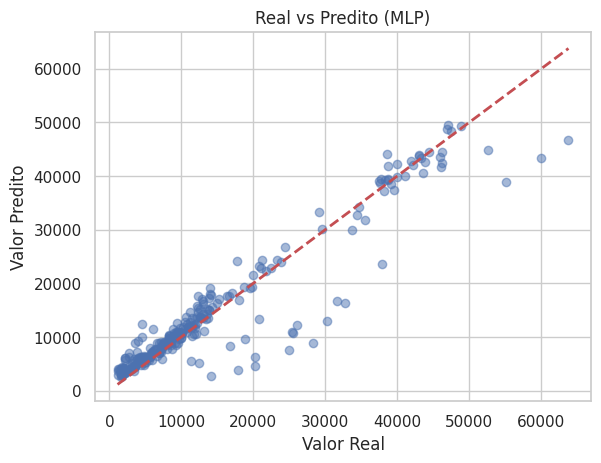

In [526]:
plt.scatter(actuals_test, preds_test_mlp, alpha=0.5)
plt.xlabel("Valor Real")
plt.ylabel("Valor Predito")
plt.title("Real vs Predito (MLP)")
plt.plot([actuals_test.min(), actuals_test.max()], [actuals_test.min(), actuals_test.max()], 'r--', linewidth=2)
plt.show()

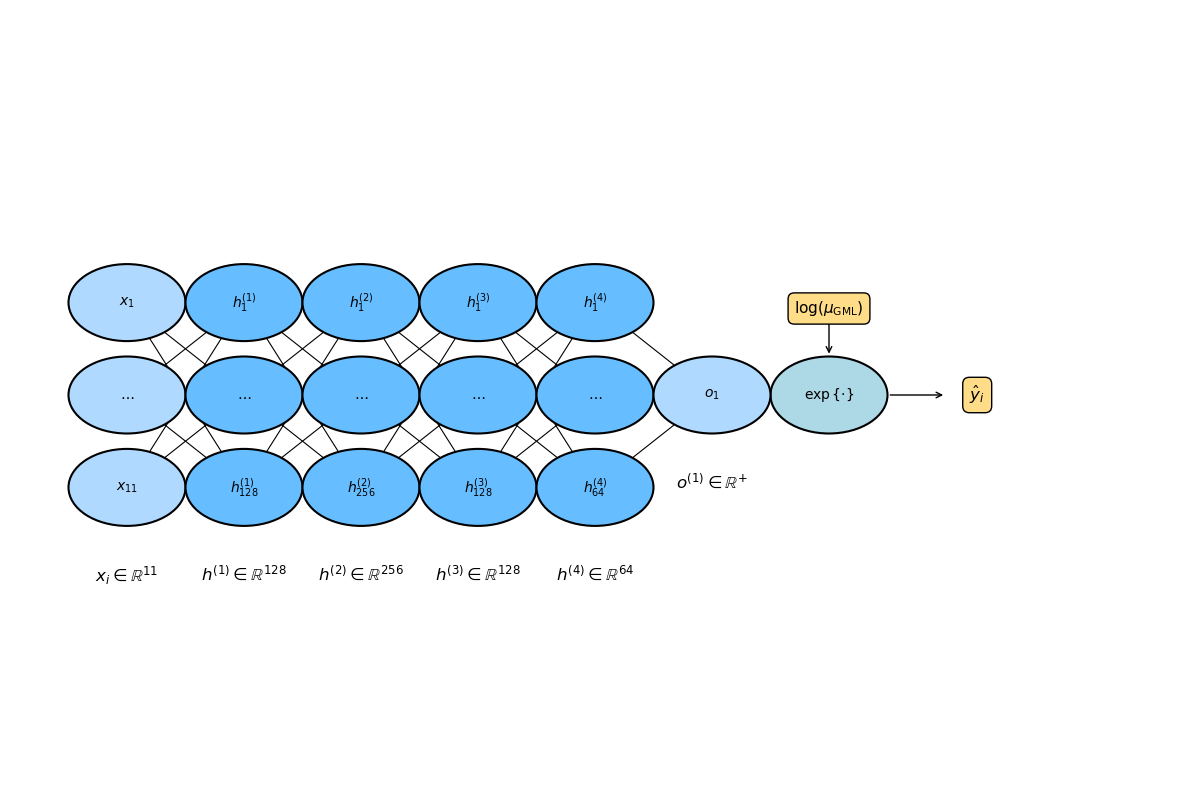

In [ ]:
import matplotlib.pyplot as plt


def draw_pann_like_cann():
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.axis("off")

    layer_sizes = [11, 128, 256, 128, 64, 1]
    layer_labels = [
        [r"$x_1$", r"$\dots$", r"$x_{11}$"],
        [r"$h^{(1)}_1$", r"$\dots$", r"$h^{(1)}_{128}$"],
        [r"$h^{(2)}_1$", r"$\dots$", r"$h^{(2)}_{256}$"],
        [r"$h^{(3)}_1$", r"$\dots$", r"$h^{(3)}_{128}$"],
        [r"$h^{(4)}_1$", r"$\dots$", r"$h^{(4)}_{64}$"],
        [r"$o_1$"],
    ]

    layer_tex = [
        r"$x_i \in \mathbb{R}^{11}$",
        r"$h^{(1)} \in \mathbb{R}^{128}$",
        r"$h^{(2)} \in \mathbb{R}^{256}$",
        r"$h^{(3)} \in \mathbb{R}^{128}$",
        r"$h^{(4)} \in \mathbb{R}^{64}$",
        r"$o^{(1)} \in \mathbb{R}^{+}$",
    ]

    h_spacing = 1.0 / (len(layer_sizes) + 4)
    r = 0.03
    y_center = 0.5
    y_spacing = 0.12
    positions = []

    for i, size in enumerate(layer_sizes):
        x = i * h_spacing
        labels = layer_labels[i]
        layer_pos = []

        for j, label in enumerate(labels):
            if len(labels) == 3:
                offsets = [+y_spacing, 0, -y_spacing]
                y = y_center + offsets[j]
            else:
                y = y_center
            layer_pos.append((x, y))

            fill = "#B0D9FF" if i == 0 or i == len(layer_sizes) - 1 else "#66BDFF"
            circ = plt.Circle((x, y), r, fc=fill, ec="black", zorder=4)
            ax.add_patch(circ)
            ax.text(x, y, label, fontsize=10, ha="center", va="center", zorder=5)

        ax.text(x, y - 0.1, layer_tex[i], fontsize=12, ha="center", va="top")
        positions.append(layer_pos)

    # Conexões
    for i in range(len(positions) - 1):
        for p_start in positions[i]:
            for p_end in positions[i + 1]:
                ax.annotate(
                    "",
                    xy=p_end,
                    xycoords="data",
                    xytext=p_start,
                    textcoords="data",
                    arrowprops=dict(arrowstyle="->", lw=0.8, color="black"),
                    zorder=1,
                )

    # Adicionar logGML → círculo com +
    x_add = len(layer_sizes) * h_spacing
    y_add = y_center
    circle = plt.Circle((x_add, y_add), r, color="lightblue", ec="black", zorder=3)
    ax.add_patch(circle)
    ax.text(x_add, y_add, r"$\exp\{\cdot\}$", fontsize=10, ha="center", va="center", zorder=4)
    # Conexão da saída do MLP até "+"
    ax.annotate(
        "",
        xy=(x_add - r, y_add),
        xytext=positions[-1][0],
        arrowprops=dict(arrowstyle="->", lw=1, color="black"),
        zorder=1,
    )

    # logGML vindo de cima
    ax.annotate(
        "",
        xy=(x_add, y_add + r),
        xytext=(x_add, y_add + 0.1),
        arrowprops=dict(arrowstyle="->", lw=1, color="black"),
        zorder=1,
    )
    ax.text(
        x_add,
        y_add + 0.1,
        r"$\log(\mu_\mathrm{GML})$",
        fontsize=11,
        ha="center",
        va="bottom",
        bbox=dict(facecolor="#FFDD88", edgecolor="black", boxstyle="round,pad=0.4"),
    )

    x_out = x_add + 0.1
    ax.annotate(
        "",
        xy=(x_out, y_add),
        xytext=(x_add + r, y_add),
        arrowprops=dict(arrowstyle="->", lw=1, color="black"),
        zorder=1,
    )
    ax.text(
        x_out + 0.02,
        y_add,
        r"$\hat{y}_i$",
        fontsize=12,
        ha="left",
        va="center",
        bbox=dict(facecolor="#FFDD88", edgecolor="black", boxstyle="round,pad=0.4"),
    )

    ax.set_xlim(-0.1, x_out + 0.2)
    ax.set_ylim(0, 1)
    plt.tight_layout()
    plt.show()


draw_pann_like_cann()